# 목차
## 1. 의료영상을 처리하는 CNN 기반 베이스 모델 구현
```
1.1. Set-up
1.2. 데이터 준비하기
1.3. 데이터 시각화
1.4. CNN 모델링
1.5. 데이터 imbalance 처리
1.6. 모델 훈련
1.7. 결과 확인
```
## 2. 데이터 augmentation 기법을 사용해서 베이스 모델과 성능 비교
```
2.1. Set-up
2.2. 데이터 준비하기 (augmentation 도입)
2.3. 데이터 시각화
2.4. CNN 모델링
2.5. 데이터 imbalance 처리
2.6. 모델 훈련
2.7. 결과 확인
2.8. 성능 비교
```
## 3. 모델 구조 변경을 통해 베이스 모델과의 성능 비교
```
3.1. Set-up
3.2. 데이터 준비하기
3.3. CNN 모델 구조 변경
3.4. 데이터 imbalance 처리
3.5. 모델 훈련
3.6. 결과 확인
3.7. 성능 비교
```
## 4. ResNet-18 모델을 구현하고 학습 성공
```
4.1. Set-up
4.2. 데이터 준비하기
4.3. ResNet-18 모델 구현
4.4. 모델 훈련
4.5. 결과 확인
```
## 5. 회고

# 1. 의료영상을 처리하는 CNN 기반 베이스 모델 구현

## 1.1. Set-up

In [1]:
# 사용할 라이브러리 불러오기

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 앞으로 필요한 변수들 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

## 1.2. 데이터 준비하기

In [3]:
# 폐렴 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train : val를 80:20으로 분할
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# NORMAL(정상) 이미지 count
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# PNEUMONIA(폐렴) 이미지 count
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
# mini-batch로 작업할 수 있도록 tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터셋 count
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

# validation 데이터셋 count
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝부분을 확인하여 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 데이터 타입을 float으로 바꾸기
# 이미지 SIZE 통일시키기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# train 데이터 셋과 validation 데이터 셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
# prepare_for_training() 함수로 데이터 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 1.3. 데이터 시각화

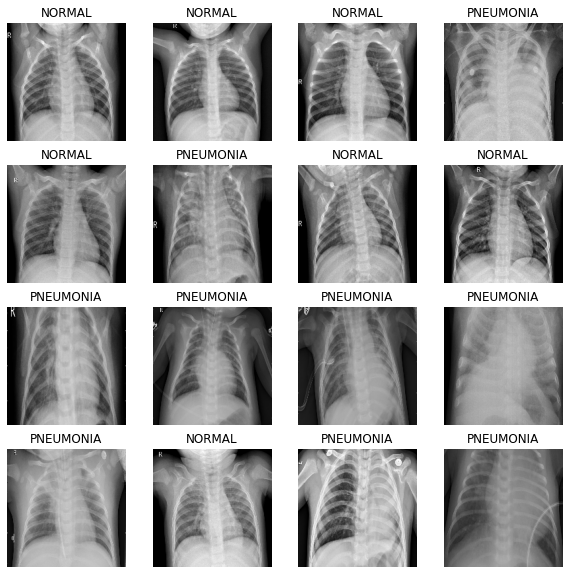

In [13]:
# train에 있는 batch 중 첫 번째 batch 추출
# 추출된 배치를 image와 label 데이터 셋으로 나누고 결과 사진 보기
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 1.4. CNN 모델링

In [14]:
# Convolution block을 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [15]:
# Dense Block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
# Batch Normalization과 Dropout 두 가지 regularization 기법 사용
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 1.5. 데이터 imbalance 처리

In [17]:
# 데이터의 imbalance 해결을 위해 Weight balancing 사용
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 1.6. 모델 훈련

In [18]:
# build_model()을 model에 선언
# loss, optimizer, metrics 설정
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [19]:
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 71s 218ms/step - loss: 0.4061 - accuracy: 0.8106 - precision: 0.9451 - recall: 0.7915 - val_loss: 0.8203 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2364 - accuracy: 0.9035 - precision: 0.9701 - recall: 0.8980 - val_loss: 1.3764 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 74s 283ms/step - loss: 0.1938 - accuracy: 0.9303 - precision: 0.9793 - recall: 0.9261 - val_loss: 0.5733 - val_accuracy: 0.7827 - val_precision: 0.7713 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 127s 489ms/step - loss: 0.1763 - accuracy: 0.9322 - precision: 0.9777 - recall: 0.9301 - val_loss: 0.2631 - val_accuracy: 0.8913 - val_precision: 0.8713 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 127s 488ms/step - loss: 0.1646 - accu

## 1.7. 결과 확인

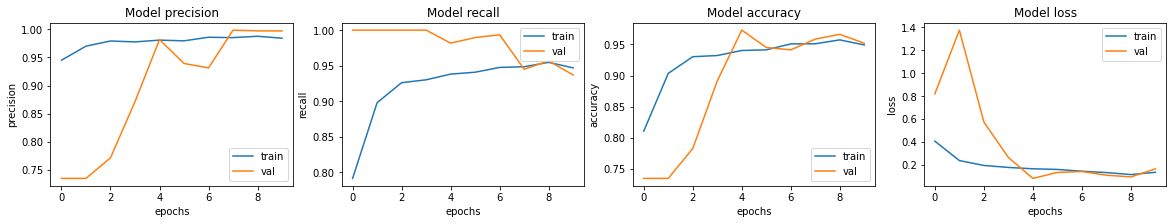

In [20]:
# Epoch별 모델의 precision, recall, accuracy, loss 그래프로 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
# 모델의 loss, accuracy, precision, recall 값 확인

loss, accuracy, precision, recall = model.evaluate(test_ds)

print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 10s 241ms/step - loss: 0.5127 - accuracy: 0.8510 - precision: 0.8249 - recall: 0.9667
Loss: 0.5126739144325256,
Accuracy: 0.8509615659713745,
Precision: 0.8249452710151672,
Recall: 0.9666666388511658


# 2. 데이터 augmentation 기법을 사용해서 베이스 모델과 성능 비교

## 2.1. Set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 베이스 모델과 성능 비교를 위해 변수 고정
BATCH_SIZE = 16
EPOCHS = 10

## 2.2. 데이터 준비하기 (augmentation 도입)

In [3]:
# 폐렴 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train : val를 80:20으로 분할
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# NORMAL(정상) 이미지 count
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])

# PNEUMONIA(폐렴) 이미지 count
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# mini-batch로 작업할 수 있도록 tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 파일 경로의 끝부분을 확인하여 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 데이터 타입을 float으로 바꾸기
# 이미지 SIZE 통일시키기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    return img, label

# train 데이터 셋과 validation 데이터 셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [4]:
# 데이터 augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분을 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 2.3. 데이터 시각화

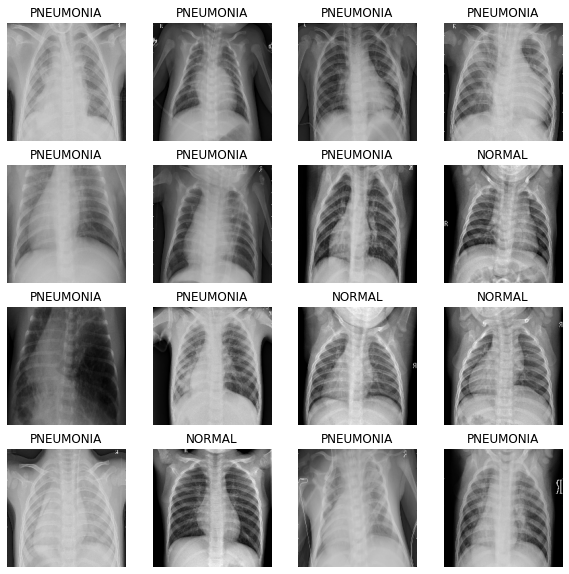

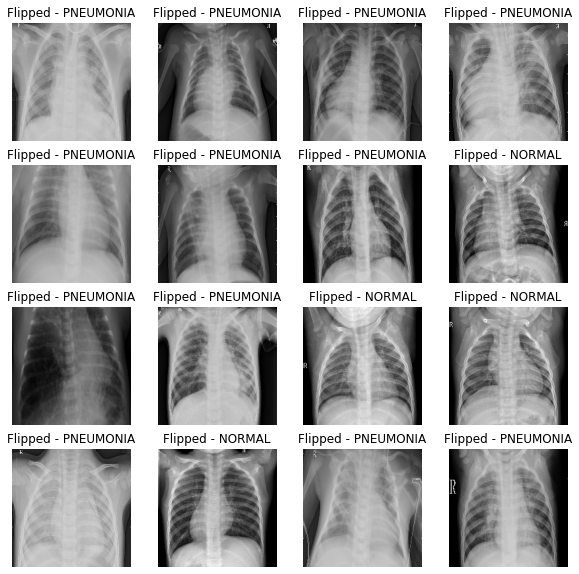

In [5]:
# 배치에서 이미지를 추출하고 좌우 반전 여부를 확인하는 함수
def show_batch_and_flipped(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(image_batch[n])  # 개별 이미지 출력
        plt.title("PNEUMONIA" if label_batch[n] else "NORMAL")
        plt.axis("off")
    
    plt.show()  # 원본 이미지 표시

    plt.figure(figsize=(10, 10))
    
    for n in range(BATCH_SIZE):
        flipped_image = np.fliplr(image_batch[n])  # 좌우 반전
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(flipped_image)  # 반전된 이미지 출력
        plt.title("Flipped - PNEUMONIA" if label_batch[n] else "Flipped - NORMAL")
        plt.axis("off")

    plt.show()  # 반전된 이미지 표시

# train에 있는 batch 중 첫 번째 batch 추출
image_batch, label_batch = next(iter(train_ds))
show_batch_and_flipped(image_batch.numpy(), label_batch.numpy())

## 2.4. CNN 모델링

In [6]:
# Convolution block을 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# Batch Normalization과 Dropout 두 가지 regularization 기법 사용
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 2.5. 데이터 imbalance 처리

In [7]:
# 데이터의 imbalance 해결을 위해 Weight balancing 사용
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

## 2.6. 모델 훈련

In [ ]:
# 모델 파라미터 설정
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [8]:
# 모델 학습
with tf.device('/GPU:0'):
    history_augment = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 72s 211ms/step - loss: 0.4087 - accuracy: 0.7950 - precision: 0.9541 - recall: 0.7613 - val_loss: 0.6690 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 205ms/step - loss: 0.2469 - accuracy: 0.9068 - precision: 0.9712 - recall: 0.9016 - val_loss: 1.3939 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2042 - accuracy: 0.9258 - precision: 0.9761 - recall: 0.9227 - val_loss: 0.3741 - val_accuracy: 0.8192 - val_precision: 0.8025 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.1907 - accuracy: 0.9303 - precision: 0.9789 - recall: 0.9264 - val_loss: 0.4316 - val_accuracy: 0.8558 - val_precision: 0.9968 - val_recall: 0.8068
Epoch 5/10
261/261 [==============================] - 58s 223ms/step - loss: 0.1712 - accura

## 2.7. 결과 확인

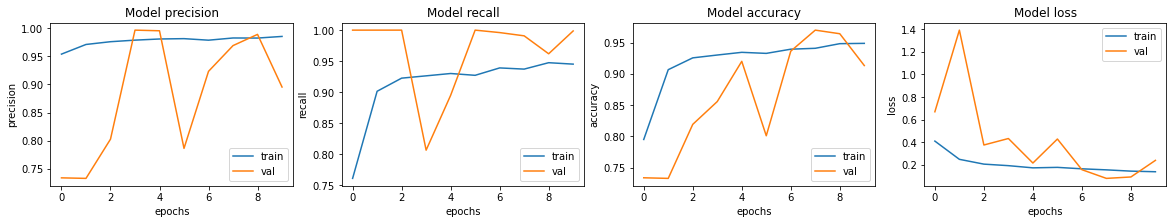

In [9]:
# Epoch별 모델의 precision, recall, accuracy, loss 그래프로 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_augment.history[met])
    ax[i].plot(history_augment.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

In [10]:
# 모델의 loss, accuracy, precision, recall 값 확인

loss, accuracy, precision, recall = model.evaluate(test_ds)

print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 1.4296 - accuracy: 0.6923 - precision: 0.6707 - recall: 0.9974
Loss: 1.4295905828475952,
Accuracy: 0.692307710647583,
Precision: 0.6706896424293518,
Recall: 0.9974358677864075


## 2.8. 성능 비교

### > 기존 CNN 모델
1) 결과:
```
Loss: 0.5127
Accuracy: 85.10%
Precision: 82.49%
Recall: 96.67%
```
2) 분석:
```
이 모델은 상당히 높은 recall (96.67%) 값을 보입니다. 이는 모델이 양성 클래스(Positive class)를 잘 식별한다는 것을 의미합니다. 그러나 precision (82.49%) 값은 상대적으로 낮아서, 많은 양성 예측 중 일부는 실제로 음성(negative)인 경우가 있을 수 있습니다.

Accuracy는 85.10%로, 꽤 높은 수준이지만, 모델이 양성 클래스를 잘 식별하는 대신 음성 클래스를 놓치거나 잘못 분류하는 경우가 발생할 수 있습니다.

Loss는 0.5127로, 상대적으로 낮은 값입니다. 이는 모델이 잘 수렴했다는 것을 의미하며, Recall과의 균형을 잘 맞추고 있는 것 같습니다.
```
3) 결론:
```
이 모델은 양성 클래스에 대해 매우 높은 recall을 제공하며, 전체적으로 안정적인 성능을 보입니다.
```
### > 기존 CNN 모델 + Augmentation 기법 도입
1) 결과:
```
Loss: 1.4296
Accuracy: 69.23%
Precision: 67.07%
Recall: 99.74%
```
2) 분석:
```
Recall 값은 매우 높습니다 (99.74%). 이는 이 모델이 양성 클래스 예측에서 매우 뛰어난 성능을 보인다는 것을 의미합니다. 그러나 Precision 값이 67.07%로 급격히 감소한 것은 많은 잘못된 양성 예측(false positives)을 초래했음을 의미합니다. 즉, 모델이 음성 클래스를 양성으로 잘못 예측하는 경우가 많아졌습니다.

Accuracy가 69.23%로 현저히 낮아졌습니다. 이는 양성 예측의 정확도가 높지만, 잘못된 예측이 많아 전체적인 성능이 떨어졌음을 시사합니다.

Loss가 1.4296로 증가한 것도 이와 연관이 있습니다. 이는 모델이 학습하는 데 있어 더 많은 오류를 범하고 있다는 것을 나타냅니다.
```
3) 결론: 
```
Augmentation을 도입했음에도 불구하고 모델이 과도하게 양성 클래스에 집중하여 성능이 저하되었습니다. 이는 오히려 잘못된 양성 예측이 많아져서 precision이 낮아지고, 결과적으로 accuracy가 떨어진 것이라고 할 수 있습니다.
val_loss가 일시적으로 증가하거나 불안정하게 보였는데, 이는 모델이 다양한 변형된 데이터를 학습하면서 더 많은 실수를 하기도 했기 때문일 수 있습니다.
```

# 3. 모델 구조 변경을 통해 베이스 모델과의 성능 비교

## 3.1. Set-up

In [47]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'  # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변수 변경
BATCH_SIZE = 32 # 16에서 32로 늘리기
EPOCHS = 10

## 3.2. 데이터 준비하기

In [48]:
# 폐렴 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train : val를 80:20으로 분할
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# NORMAL(정상) 이미지 count
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])

# PNEUMONIA(폐렴) 이미지 count
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# mini-batch로 작업할 수 있도록 tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 파일 경로의 끝부분을 확인하여 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 데이터 타입을 float으로 바꾸기
# 이미지 SIZE 통일시키기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    return img, label

# train 데이터 셋과 validation 데이터 셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## 3.3. CNN 모델 구조 변경

In [49]:
# Convolution block을 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),  # LeakyReLU 추가
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# Batch Normalization과 Dropout 두 가지 regularization 기법 사용
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),  # 필터 개수 추가
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.GlobalAveragePooling2D(),  # Flatten 대신 GlobalAveragePooling2D 사용
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 3.4. 데이터 imbalance 처리

In [50]:
# 데이터의 imbalance 해결을 위해 Weight balancing 사용
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 3.5. 모델 훈련

In [51]:
# 데이터셋을 배치 처리하고 반복하도록 수정
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).repeat()  # 데이터셋을 반복하도록 수정

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).repeat()  # 데이터셋을 반복하도록 수정

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)  # 반복할 필요 없음 (테스트용)

# 모델 컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # 이 값은 여전히 유지합니다.
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # 이 값도 여전히 유지합니다.
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 39s 287ms/step - loss: 0.4150 - accuracy: 0.8130 - precision: 0.9592 - recall: 0.7820 - val_loss: 0.5890 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 37s 288ms/step - loss: 0.2531 - accuracy: 0.9056 - precision: 0.9757 - recall: 0.8955 - val_loss: 0.7683 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 37s 288ms/step - loss: 0.2081 - accuracy: 0.9254 - precision: 0.9774 - recall: 0.9211 - val_loss: 0.9128 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 37s 287ms/step - loss: 0.1740 - accuracy: 0.9379 - precision: 0.9833 - recall: 0.9323 - val_loss: 1.1665 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 37s 283ms/step - loss: 0.1528 - accura

## 3.6. 결과 확인

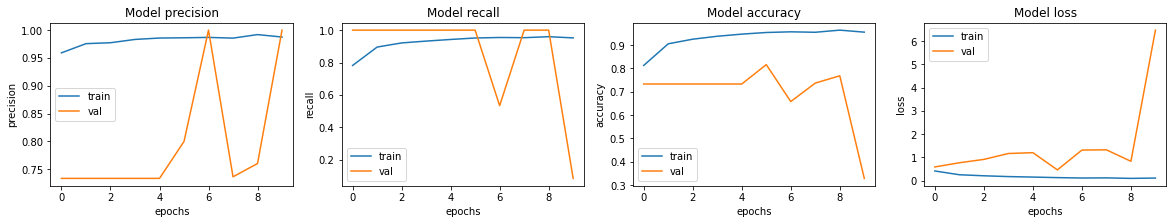

In [53]:
# Epoch별 모델의 precision, recall, accuracy, loss 그래프로 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
# 모델의 test 데이터셋에 대한 평가 (loss, accuracy, precision, recall)
loss, accuracy, precision, recall = model.evaluate(test_ds)

print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 236ms/step - loss: 5.7565 - accuracy: 0.4006 - precision: 1.0000 - recall: 0.0410
Loss: 5.756494522094727,
Accuracy: 0.4006410241127014,
Precision: 1.0,
Recall: 0.041025642305612564


## 3.7. 성능 비교

### 모델 구조 변경 사항:

- LeakyReLU 추가:
```
LeakyReLU(alpha=0.1)를 사용하여, ReLU가 음수 부분에서 0으로 출력을 제한하는 문제를 완화하고, 그 대신 작은 기울기를 허용합니다. 일부러 음수 기울기를 유지하여 모델이 더 원활하게 학습하도록 돕습니다.

- Convolution 필터 개수 증가:
```
필터 개수를 256으로 증가시키는 방식으로 더 많은 특징을 추출합니다. 더 많은 필터를 통해 더 많은 특성을 학습할 수 있습니다.

- GlobalAveragePooling2D 사용:
```
모델이 학습하는 동안 파라미터의 수를 줄이면서도 중요한 특징을 학습할 수 있도록 돕습니다. Flatten을 사용하면 파라미터가 너무 많아지는데, GlobalAveragePooling2D는 평균값을 취함으로써 출력 크기를 줄입니다. 이는 학습을 보다 안정적으로 만들며, 모델 성능 향상에 도움이 될 수 있습니다.
```

### > 변경한 CNN 모델
1) 결과:
```
Loss: 5.7565
Accuracy: 40.06%
Precision: 100.00%
Recall: 4.10%
```
2) 분석:
```
Precision 값이 100%라는 것은 모델이 예측한 양성 클래스 중 모든 예측이 실제로 양성이었음을 의미합니다. 그러나 Recall 값은 4.10%로 매우 낮습니다. 이는 모델이 실제 양성 클래스의 대부분을 놓치고 있다는 것을 뜻합니다. 모델이 양성 클래스에서 거의 모든 예측을 부정으로 분류했기 때문입니다.

Accuracy가 40.06%로 매우 낮습니다. 이는 모델이 전체적으로 성능이 좋지 않다는 것을 나타냅니다.

Loss가 5.7565로 매우 높은 값입니다. 이는 모델이 훈련 데이터에 대해 거의 아무런 예측을 하지 못하고 있다는 것을 의미합니다. 큰 손실 값은 모델이 적절하게 수렴하지 않았음을 시사합니다.
```
3) 결론: 
```
이 모델에서 Precision은 100%에 달하지만 Recall이 매우 낮은 이유는 주로 불균형 데이터나 과도한 양성 예측 회피에서 비롯된 문제입니다.
모델이 양성 예측을 매우 신중하게 다루면서, 양성 클래스를 거의 예측하지 않거나 음성 클래스로 예측할 확률이 높아졌기 때문에 Precision은 높지만, Recall이 크게 떨어졌습니다. 

이러한 현상을 개선하기 위해서는 다음과 같은 방법을 고려할 수 있습니다.

- 불균형 데이터 처리: 데이터셋을 균형 있게 조정하거나, 가중치 조정(class weights)을 사용하여 양성 클래스와 음성 클래스에 대한 모델의 예측을 균형 있게 유도할 수 있습니다.
- Threshold 조정: 양성 예측을 더 많이 할 수 있도록 임계값을 낮춰서 Recall을 높일 수 있습니다.
- 기타 데이터 증강 기법 사용: 양성 클래스의 샘플을 추가로 생성하거나 SMOTE와 같은 기술을 통해 불균형 문제를 해결할 수 있습니다.
```

# 4. ResNet-18 모델을 구현하고 학습 성공

## 4.1. Set-up

In [1]:
# 사용할 라이브러리 불러오기

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변수 변경
BATCH_SIZE = 32 # 16에서 32로 늘리기
EPOCHS = 10

## 4.2. 데이터 준비하기

In [3]:
# 폐렴 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train : val를 80:20으로 분할
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# NORMAL(정상) 이미지 count
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])

# PNEUMONIA(폐렴) 이미지 count
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# mini-batch로 작업할 수 있도록 tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 파일 경로의 끝부분을 확인하여 양성과 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 데이터 타입을 float으로 바꾸기
# 이미지 SIZE 통일시키기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    label = tf.reshape(label, (-1,))  # 라벨을 (None,)으로 reshape (one-hot 필요 없음)
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    return img, label

# train 데이터 셋과 validation 데이터 셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 배치화 및 prefetch (배치화는 한 번만 적용)
train_ds = train_ds.shuffle(len(train_filenames)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

## 4.3. ResNet-18 모델 구현

In [4]:
from tensorflow.keras import layers, models

# Residual block 정의
def residual_block(inputs, filters, strides=1):
    shortcut = inputs

    # 1st convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2nd convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Adjust the shortcut if needed
    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

In [5]:
# ResNet-18 정의
def build_resnet18(input_shape=(180, 180, 3), num_classes=1):  # num_classes를 1000에서 1로 변경
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)

    # Global Average Pooling and fully connected layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # softmax 대신 sigmoid 활성화 함수 사용

    # Create the model
    model = models.Model(inputs, outputs)
    return model

In [6]:
# 모델 생성 및 요약
resnet18_model = build_resnet18()
resnet18_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 4.4. 모델 훈련

In [7]:
# 모델 컴파일
resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[ 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)

In [8]:
# 모델 학습
history_resnet18 = resnet18_model.fit(
    train_ds.repeat(),  # 데이터셋을 반복하도록 설정
    validation_data=val_ds.repeat(),  # 검증 데이터셋도 반복
    epochs=EPOCHS, 
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # steps_per_epoch를 배치 수에 맞게 설정
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE   # validation_steps도 마찬가지로 설정
)

Epoch 1/10
130/130 [==============================] - 60s 141ms/step - loss: 0.2088 - precision: 0.9429 - recall: 0.9483 - accuracy: 0.9187 - val_loss: 6.8392 - val_precision: 0.7334 - val_recall: 1.0000 - val_accuracy: 0.7334
Epoch 2/10
130/130 [==============================] - 51s 388ms/step - loss: 0.1028 - precision: 0.9754 - recall: 0.9760 - accuracy: 0.9639 - val_loss: 4.3704 - val_precision: 0.7334 - val_recall: 1.0000 - val_accuracy: 0.7334
Epoch 3/10
130/130 [==============================] - 50s 385ms/step - loss: 0.0742 - precision: 0.9793 - recall: 0.9809 - accuracy: 0.9704 - val_loss: 4.3562 - val_precision: 1.0000 - val_recall: 0.1252 - val_accuracy: 0.3584
Epoch 4/10
130/130 [==============================] - 49s 378ms/step - loss: 0.0668 - precision: 0.9819 - recall: 0.9839 - accuracy: 0.9745 - val_loss: 4.1892 - val_precision: 1.0000 - val_recall: 0.2410 - val_accuracy: 0.4434
Epoch 5/10
130/130 [==============================] - 49s 380ms/step - loss: 0.0601 - precis

## 4.5. 결과 확인

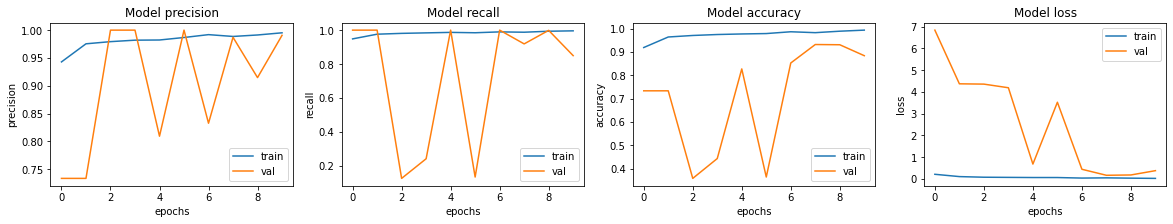

In [9]:
# Epoch별 모델의 precision, recall, accuracy, loss 그래프로 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].plot(history_resnet18.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

In [16]:
# test 데이터셋에 배치 적용 후 prefetch 적용
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# 모델의 test 데이터셋에 대한 평가 (loss, accuracy, precision, recall)
loss, accuracy, precision, recall = resnet18_model.evaluate(test_ds)

# 결과 출력
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 266ms/step - loss: 0.7001 - precision: 0.7794 - recall: 0.9513 - accuracy: 0.8013
Loss: 0.7001004815101624,
Accuracy: 0.779411792755127,
Precision: 0.9512820243835449,
Recall: 0.8012820482254028


# 5. 회고

CNN 모델의 구조를 변경하여 성능 향상을 시도했으나, 만족스러운 결과를 얻지 못했습니다. 하이퍼파라미터 조정, Convolution filter 추가, Dropout 레이어 추가 등 다양한 접근 방식을 시도했지만, 모델의 성능 개선에는 한계가 있었습니다.

이후 사전 학습된(pre-trained) 모델을 활용하여 파인튜닝(fine-tuning)을 시도해볼 계획입니다. 

직접 모델 구조를 수정해보는 과정에서 동영상 강의를 통해 배운 내용을 보다 심층적으로 이해할 수 있었습니다.